<a href="https://colab.research.google.com/github/MNKCrypto/dataanalysis-python/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check the pytorch version
torch.__version__

'2.8.0+cu126'

In [2]:
#Setup device-agnostic code
#Will use GPU if available for faster computing if not will fallback to CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


Using device: cuda


In [5]:
# Pickup a linear regression sample equation => y = mx + c
m = 0.7
c = 0.3

# Building range of values for x

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
Y = m*X + c

print(f"X - {X[:10]}, Y - {Y[:10]}")

X - tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]), Y - tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [6]:
# Prepping up the training and testing data by split

train_split = int (0.8 * len(X))
X_train,Y_train = X[:train_split],Y[:train_split]
X_test,Y_test = X[train_split:],Y[train_split:]
print(f"Length of the training dataset = X - {len(X_train)} Y - {len(Y_train)}")
print(f"Length of the testing dataset = X - {len(X_test)} Y - {len(Y_test)}")

Length of the training dataset = X - 40 Y - 40
Length of the testing dataset = X - 10 Y - 10


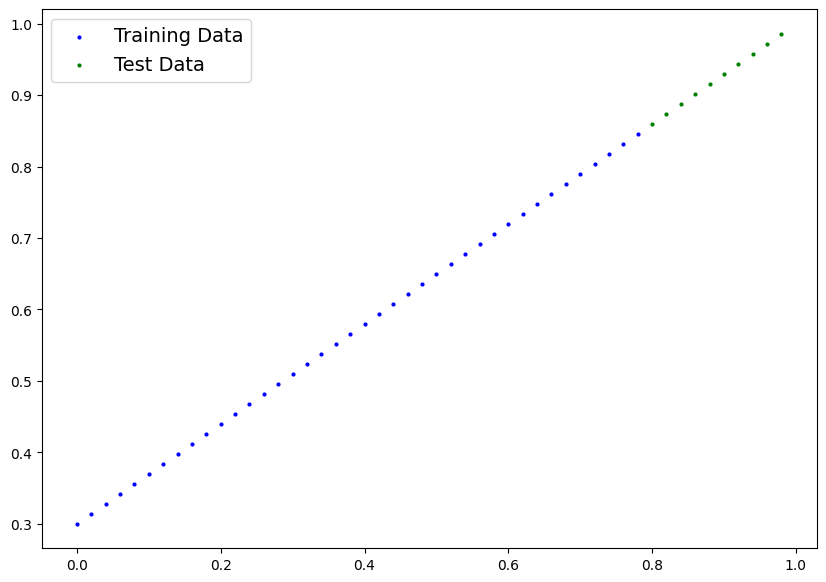

In [7]:
#Plot the data
def plot_predictions(train_data = X_train,
                     train_labels = Y_train,
                     test_data = X_test,
                     test_labels = Y_test,
                     predictions=None):

  """
  Plots training data , test data and compares predictions.
  """

  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c='b',s=4,label = "Training Data") # c-> color,#s->Size of the the scatter dots
  plt.scatter(test_data,test_labels,c='g',s=4,label = "Test Data") # c-> color,#s->Size of the the scatter dots

  if predictions is not None:
    plt.scatter(test_data,predictions,c='r',s=4,label = "Predictions") # c-> color,#s->Size of the the scatter dots
  plt.legend(prop={"size":14})

plot_predictions()

In [10]:
#Building a Linear Model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    #Assign random values to the two parameters m and c
    self.m = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    self.c= nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

#Forward method to perform computation
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.m * x + self.c


In [11]:
torch.manual_seed(42)

model_1 = LinearRegressionModel()

model_1, model_1.state_dict()

(LinearRegressionModel(),
 OrderedDict([('m', tensor([0.3367])), ('c', tensor([0.1288]))]))

In [14]:
#Move the model to GPU
model_1.to(device)
next(model_1.parameters()).device

#Put data on the target device as well

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [20]:
#Training the model


#1. Define a loss function

loss_fn = nn.L1Loss()

#2. Define a optimizer

optimizer = torch.optim.Adam(lr=0.01,params=model_1.parameters())


epochs=200

for epoch in range(epochs):

  #1. Set the training mode
  model_1.train()

  #2. Forward pass
  y_pred = model_1.forward(X_train)

  #3. Calculate the loss
  loss = loss_fn(y_pred,Y_train)

  #4. Zero the grad
  optimizer.zero_grad()

  #5. backpropagration
  loss.backward()

  #6. Optimizer step
  optimizer.step()


  #Testing mode

  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred,Y_test)

  if epoch % 10 == 0:
    print(f"Epoch : {epoch}| Loss: {loss} | Test Loss : {test_loss}")


Epoch : 0| Loss: 0.2572813630104065 | Test Loss : 0.40003618597984314
Epoch : 10| Loss: 0.11828134208917618 | Test Loss : 0.21103624999523163
Epoch : 20| Loss: 0.026902804151177406 | Test Loss : 0.03443029522895813
Epoch : 30| Loss: 0.02953474037349224 | Test Loss : 0.029879290610551834
Epoch : 40| Loss: 0.02363811992108822 | Test Loss : 0.06569613516330719
Epoch : 50| Loss: 0.012545222416520119 | Test Loss : 0.015546673908829689
Epoch : 60| Loss: 0.005088135600090027 | Test Loss : 0.011914044618606567
Epoch : 70| Loss: 0.002686708467081189 | Test Loss : 0.008320611901581287
Epoch : 80| Loss: 0.00035117269726470113 | Test Loss : 0.0038587271701544523
Epoch : 90| Loss: 0.0013337157433852553 | Test Loss : 0.0005564510938711464
Epoch : 100| Loss: 0.001616150140762329 | Test Loss : 0.00310150976292789
Epoch : 110| Loss: 0.002368675312027335 | Test Loss : 0.00485806493088603
Epoch : 120| Loss: 0.002158337039873004 | Test Loss : 0.0007806599023751915
Epoch : 130| Loss: 0.0025731392670422792 

In [25]:
#Estimated model parameters
print(f"Actual - m -> {m}, c-> {c}. Estimated - {model_1.state_dict()}")

Actual - m -> 0.7, c-> 0.3. Estimated - OrderedDict({'m': tensor([0.6983], device='cuda:0'), 'c': tensor([0.2983], device='cuda:0')})


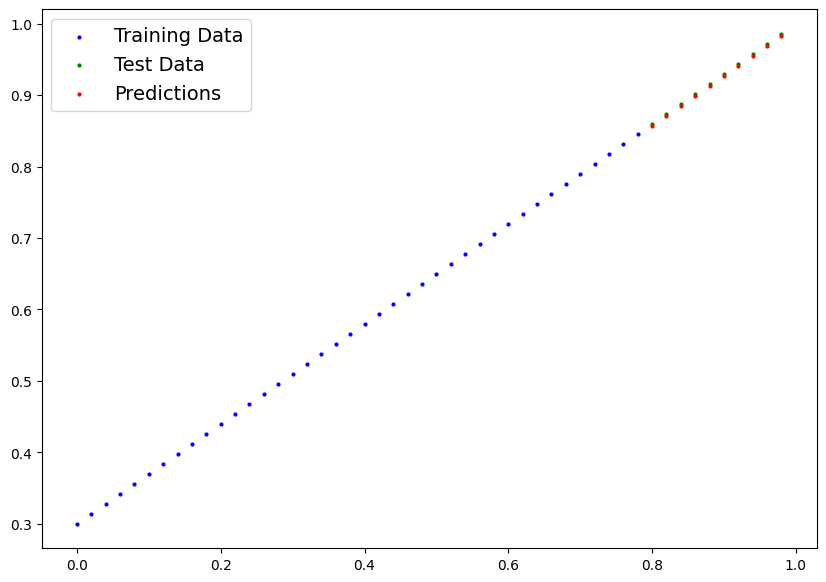

In [28]:
#Plotting
plot_predictions(predictions=test_pred.cpu().numpy())

In [30]:
#Save and load the models
from pathlib import Path

#Create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_SAVE_PATH = MODEL_PATH/"linear_regression_1.pth"

# Save the mode
print(f"Saving the model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving the model to : models/linear_regression_1.pth


In [33]:
#Loading back the model

model_2 = LinearRegressionModel()
model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_2.to(device)
model_2.state_dict(),model_1.state_dict()

(OrderedDict([('m', tensor([0.6983], device='cuda:0')),
              ('c', tensor([0.2983], device='cuda:0'))]),
 OrderedDict([('m', tensor([0.6983], device='cuda:0')),
              ('c', tensor([0.2983], device='cuda:0'))]))